In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import tree
from sklearn.model_selection import cross_val_score
import urllib
import graphviz

Wczytanie danych

In [170]:
link = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
f = urllib.request.urlopen(link)
data = pd.read_csv(f, sep=",", header=None)
data.columns = ["class", "Alcohol", "Malic.acid", "Ash", "Alcalinity.of.ash", "Magnesium", "Total.phenols", "Flavanoids", "Nonflavanoid.phenols", "Proanthocyanins", "Color.intensity", "Hue", "OD280OD315.of.diluted.wines", "Proline"]

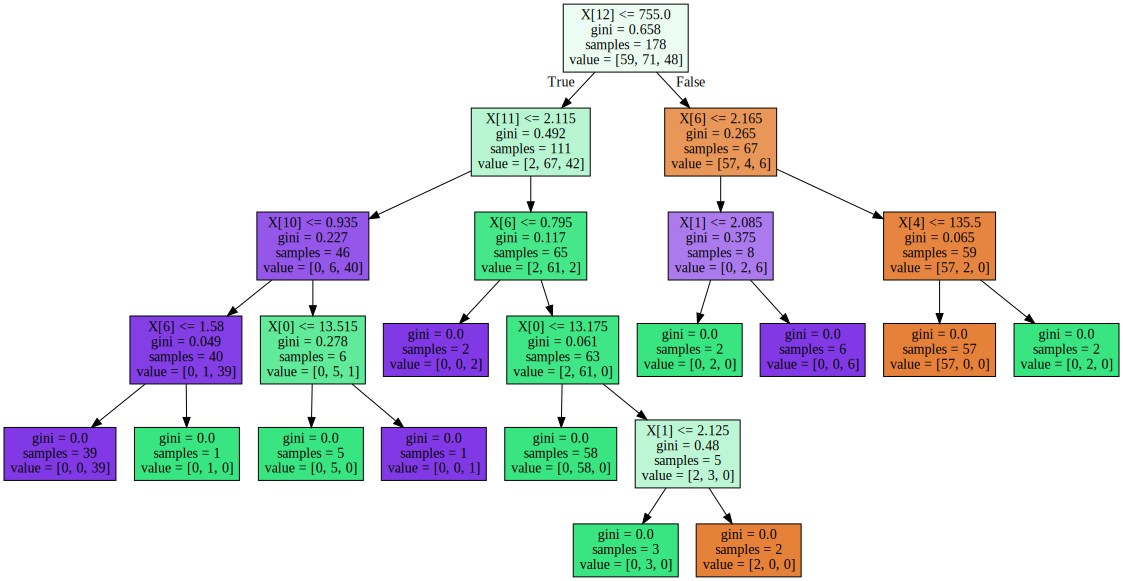

In [171]:
tree_classifier = tree.DecisionTreeClassifier()
tree_classifier_fit = tree_classifier.fit(data[data.columns[1:]], data["class"])
graph_data = tree.export_graphviz(tree_classifier_fit, filled = True, out_file=None) 
graph = graphviz.Source(graph_data) 
graph

Skuteczność pełnego drzewa przez powtórne podstawienie i kroswalidację

In [172]:
accuracy_self = np.round(tree_classifier.score(data[data.columns[1:]],data["class"]), 2)   #skuteczność przy powtórnym podstawieniu
accuracy_crossval = np.round(cross_val_score(tree_classifier, data[data.columns[1:]], data["class"], cv = 5).mean(),2) #skuteczność przy kroswalidacji
print("Skuteczność przy powtórnym podstawieniu =", accuracy_self)
print("Skuteczność przy kroswalidacji =", accuracy_crossval)

Skuteczność przy powtórnym podstawieniu = 1.0
Skuteczność przy kroswalidacji = 0.85


Wyznaczenie współczynników alfa przy kolejnych cięciach drzewa pierwotnego

In [173]:
d = tree_classifier_fit.cost_complexity_pruning_path(data[data.columns[1:]],data["class"])
ccp_alphas = d.ccp_alphas.reshape(len(d.ccp_alphas),1)

W R bierzemy alfę dla minimalnej wartości xerror. Xerror to estymator błędu predykcji na podstawie kroswalidacji (The xerror column contains of estimates of cross-validated prediction error for different numbers of splits (nsplit)). Dlatego tutaj w pętli dla każdej wartości alfa tworzę klasyfikator i wyznaczam jego dokładność poprzez kroswalidację. Wartość maksymalna w tablicy accuracy odpowiada wartości minimalnej xerror w cptable w R. 

In [174]:
accuracy = np.array([])
for i in range(len(ccp_alphas)):
    pruned_tree_classifier = tree.DecisionTreeClassifier(ccp_alpha=ccp_alphas[i])
    
    accuracy = np.append(accuracy, cross_val_score(pruned_tree_classifier, data[data.columns[1:]], data["class"], cv = 5).mean())
max(accuracy)

0.8993650793650794

Stworzenie i narysowanie optymalnego drzewa decyzyjnego z odpowiednią wartością alfa (dla której skuteczność jest największa).

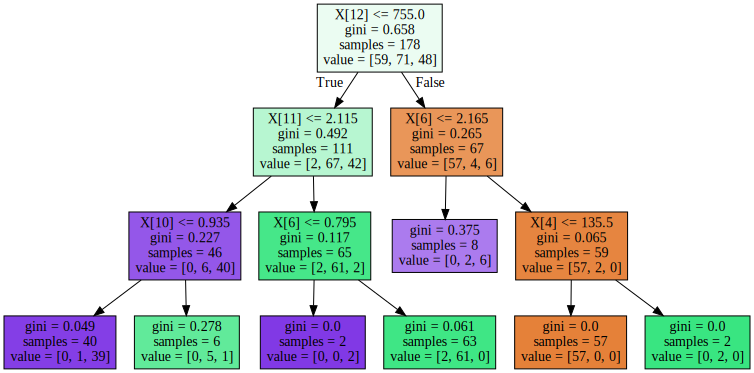

In [175]:
optimal_tree_classifier = tree.DecisionTreeClassifier(ccp_alpha = ccp_alphas[np.argmax(accuracy)])
optimal_tree_fit = optimal_tree_classifier.fit(data[data.columns[1:]], data["class"])
graph_data_pruned = tree.export_graphviz(optimal_tree_fit, filled = True, out_file=None) 
graph_pruned = graphviz.Source(graph_data_pruned) 
graph_pruned

Porównanie skuteczności drzewa optymalnego dla powtórnego podstawienia i kroswalidacji.

In [176]:
opt_accuracy_self = np.round(optimal_tree_classifier.score(data[data.columns[1:]],data["class"]), 2)   #skuteczność przy powtórnym podstawieniu
opt_accuracy_crossval = np.round(cross_val_score(optimal_tree_classifier, data[data.columns[1:]], data["class"], cv = 5).mean(),2) #skuteczność przy kroswalidacji
print("Skuteczność przy powtórnym podstawieniu dla drzewa optymalnego = %f vs %f dla nieoptymalnego" % (opt_accuracy_self,accuracy_self))
print("Skuteczność przy kroswalidacji dla drzewa optymalnego = %f vs %f dla nieoptymalnego" % (opt_accuracy_crossval,accuracy_crossval))

Skuteczność przy powtórnym podstawieniu dla drzewa optymalnego = 0.970000 vs 1.000000 dla nieoptymalnego
Skuteczność przy kroswalidacji dla drzewa optymalnego = 0.900000 vs 0.850000 dla nieoptymalnego


Wyznaczenie dokładności i różnicy rozmiaru dla drzew optymalnych i nieoptymalnych skonstruowanych na podstawie różnej liczby atrybutów. Za rozmiar rozumie się liczbę liści w drzewie.

In [178]:
attributes_number = np.arange(len(data.columns)-2)+2   #kolejne liczby atrybutów
accuracy_optimal = np.array([])     #dokładności drzew optymalnych
accuracy_non_optimal = np.array([])  #dokładności drzew nieoptymalnych
size_diff_table = np.array([])      #różnice w wielkościach pomiędzy drzewami nieoptymalnymi i optymalnymi
for j in attributes_number:    #iterowanie po liczbie atrybutów
    tree_classifier_temp = tree.DecisionTreeClassifier().fit(data[data.columns[1:j+1]],data["class"])  #stworzenie drzewa nieoptymalnego
    tree_leaves = tree_classifier_temp.get_n_leaves()    #zapisanie rozmiaru drzewa nieoptymalnego
    accuracy_non_optimal = np.append(accuracy_non_optimal, cross_val_score(tree_classifier_temp, data[data.columns[1:j+1]], data["class"], cv = 5).mean())  #wyznaczenie dokładności drzewa nieoptymalnego
    d = tree_classifier_temp.cost_complexity_pruning_path(data[data.columns[1:j+1]],data["class"])   #wyznaczenie wsp. alpha
    ccp_alphas = d.ccp_alphas.reshape(len(d.ccp_alphas),1)
    accuracy_temp = np.array([])    #dokładność drzew dla kolejnych wsp. alpha
    for i in range(len(ccp_alphas)):   #iterowanie po indeksie wsp. alpha
        pruned_tree_classifier = tree.DecisionTreeClassifier(ccp_alpha=ccp_alphas[i])   #utworzenie drzewa dla i-tej alphy
        accuracy_temp = np.append(accuracy_temp, cross_val_score(pruned_tree_classifier, data[data.columns[1:j+1]], data["class"], cv = 5).mean())   #wyznaczenie dokładności i-tego drzewa
    optimal_tree_fit = tree.DecisionTreeClassifier(ccp_alpha = ccp_alphas[np.argmax(accuracy_temp)]).fit(data[data.columns[1:j+1]],data["class"])   #utworzenie drzewa z alphą, dla której osiągnięto największą dokładność
    opt_leaves = optimal_tree_fit.get_n_leaves()   #zapisanie rozmiaru drzewa optymalnego
    accuracy_optimal = np.append(accuracy_optimal, cross_val_score(optimal_tree_fit, data[data.columns[1:j+1]], data["class"], cv = 5).mean())
    size_diff_table = np.append(size_diff_table, tree_leaves - opt_leaves)

Rysowanie zależności różnicy wielkości i dokładności od liczby atrybutów.

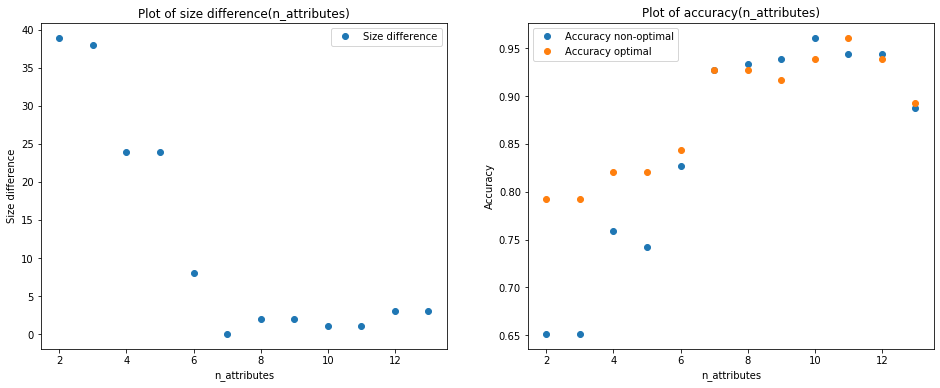

In [179]:
fig, axs = plt.subplots(1, 2, figsize = [16, 6])
axs[0].plot(attributes_number, size_diff_table, 'o', label = "Size difference")
axs[1].plot(attributes_number, accuracy_non_optimal, 'o', label = "Accuracy non-optimal")
axs[1].plot(attributes_number, accuracy_optimal, 'o', label = "Accuracy optimal")
axs[0].set_title("Plot of size difference(n_attributes)")
axs[1].set_title("Plot of accuracy(n_attributes)")
axs[0].set_xlabel("n_attributes")
axs[1].set_xlabel("n_attributes")
axs[0].set_ylabel("Size difference")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()
plt.show(fig)

Jak widać na wykresach, różnice w rozmiarach i dokładności drzew optymalnych i nieoptmalnych zacierają się w momencie wzięcia pod uwagę więcej niż 6 atrybutów. Dokładność w większości przypadków jest większa przy użyciu drzewa optymalnego.